**Overview**

The goal is to implement the KLT tracking tracking algorithm.

# Environment setup

In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/your_path')
!pip install opencv-python==4.5.3.*

In [3]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV version: 4.5.3
NumPy version:  1.19.5


Number of detected keypoints = 161


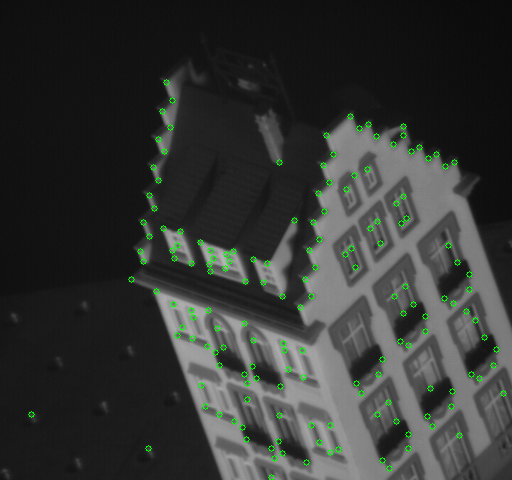

In [4]:
# The purpose of this code block is to verify that we can access the hotel 
#  images, and to illustrate examples of keypoints.
# Parts of this example were borrowed from 
#  https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html

DISPLAY_RADIUS = 3
DISPLAY_COLOR  = (0, 255, 0)

def keypointDetectionDemo(im0):
  # find image locations that may be good for tracking
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2, 
                       minDistance = 7,  
                       blockSize = 5 )     
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # now corners should contain an array of (floating point) pixel locations 
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # convert to kx2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  # draw a small circle at each detected point and display the result
  im0color = cv2.cvtColor(im0, cv2.COLOR_GRAY2BGR)
  cornersInt = np.intp(np.round(corners)) # convert to integers used for indexing 
  for i in cornersInt:
    x, y = i.ravel()      # returns a contiguous flattened array
    cv2.circle(im0color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)

  cv2_imshow(im0color)
  return
  
# load and display a sample image, detect features, and display the results
im0 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
keypointDetectionDemo(im0)


In [5]:
def linear_filter(img_in, kernel = np.array([
          [1, 4, 7, 4, 1],
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0):
  '''Filter an input image by applying cross-correlation with a kernel.

  Input: 
    img_in: a grayscale image of any size larger than the kernel
    kernel: a 2D array of floating-point values;
     you may assume that this array is square, 
     with an odd number of rows and an odd number of columns;
     use the *center* of this kernel as its point of reference for filtering.

  Output:
    img_out: an image with the same row/column size as img_in, 
     but each pixel is a floating-point value;
     apply the kernel only at locations where it fits entirely within the 
     input image; 
     the remaining pixels (near the outside border of the output image)
     must be set to zero;
     for any negative values, take the absolute value;
     clip the final output so that every pixel value lies in the range 0 to 255.

  TO DO: implement the function.
  '''
  kx = np.shape(kernel)[0]
  ky = np.shape(kernel)[0]
  ix = np.shape(img_in)[0]
  iy = np.shape(img_in)[1]
  img_ext = np.zeros((ix + 2*kx - 2, iy + 2*ky - 2), dtype=np.float32)
  img_ext[kx-1:kx-1 + ix, ky-1:ky-1 + iy] = img_in
  img_out = np.zeros((ix + kx-1, iy + ky-1), dtype=np.float32)
  
  mod_k = np.flip(kernel)
  for i in range(np.shape(img_out)[1]):
    for j in range(np.shape(img_out)[0]):
      img_out[j,i] = np.sum(mod_k*img_ext[j:kx + j, i:ky+i])
  #img_out = np.zeros((300, 400), dtype=np.float32)   # Temporary assignment; replace with your code
  img_out = img_out[np.int((kx -1)/2):np.int((kx -1)/2)+ix, np.int((ky -1)/2):np.int((ky -1)/2)+iy]
  img_out[img_out > 255] = 255
  img_out[img_out < 0] = np.abs(img_out[img_out < 0])
  return img_out # Each pixel must be of type np.float32

# Tracking

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints that were detected in the previous code example. Those keypoints were detected in image 0 of the hotel sequence, and the goal is to track them throughout images 1 to 50.

The KLT procedure operates on a pair of images that were captured at times t and t+1. For a given keypoint at (x, y) at time t, the procedure tries to find the new location (x', y') of the same keypoint at time t+1.  For reference, the following pseudocode is from the lecture slides.  
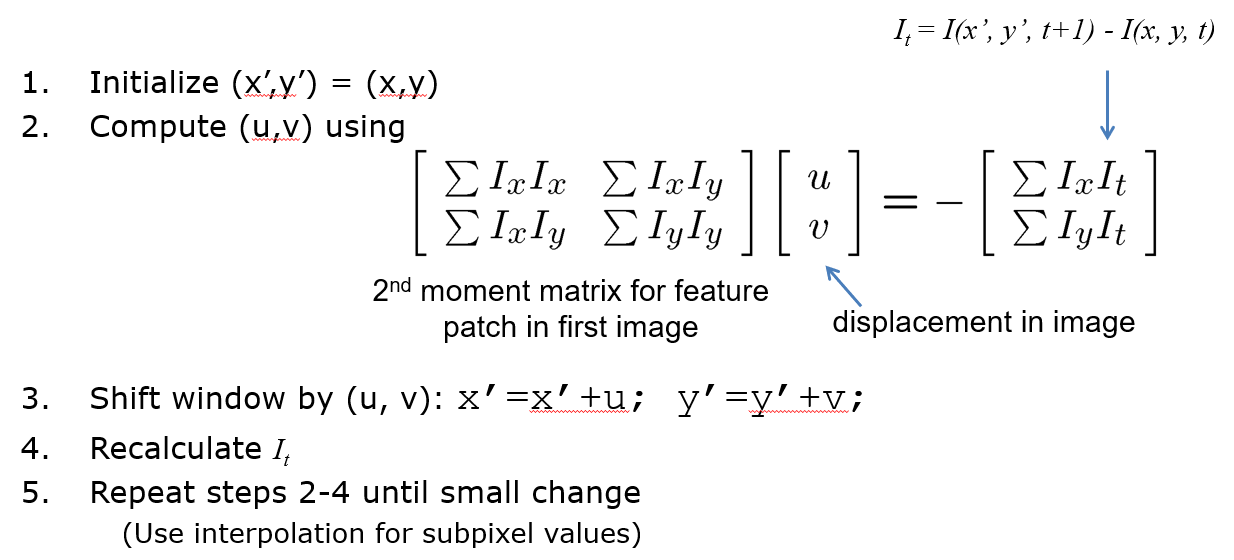


The KLT tracking procedure assumes small movements of keypoints from t to t+1. For this reason, tracking needs to be performed at subpixel resolution. Keypoint locations therefore need to be maintained using floating point values. 

The matrix equation depends on spatial gradients, which can be noisy. For this reason, you should perform smoothing of the spatial gradients when computing these matrices.

You *are* allowed to use the OpenCV function `getRectSubPix`, which takes an image location at subpixel resolution, and interpolates neighboring pixel values to return a small region of interest from the image. For computing the summations in the pseudocode, it is suggested that you use a window size of 15x15 surrounding the keypoint. Some useful functions here are `np.sum`, `np.multiply`, etc. 




The first function that you should implement is **`getNextPoints`** in the next code block. It should apply the KLT procedure using a pair of images for a given collection of feature points. For each feature point in an image at time t, the procedure tries to find the location of the corresponding point in an image at time t+1.

It is likely that some of the keypoints will eventually move out of the image frame as they are tracked over the entire sequence. To handle these situations in a simple way, it is suggested that you maintain a `movedOutFlag` vector of True/False values. If an element in `movedOutFlag` is False, then the associated keypoint is inside the image frame and should be processed; but if True, then `getNextPoints` should ignore that keypoint.

In [7]:
def getNextPoints(im1, im2, xy, movedOutFlag):
    '''Track keypoints from image im1 to image im2
     Input:
      im1: grayscale image at time t; shape (m, n)
      im2: grayscale image at time t+1; shape (m, n)
      xy:  a numpy array of size kx2, where k is the number of keypoints
       Each keypoint is of the form [x, y], with both in floating-point format
     Output:
      xy2: updated keypoint locations; same format as xy input 
      movedOutFlag: array of True/False values, of size kx1, 
       to indicate whether each associated
       keypoint has moved outside the dimensions of the image array

     TO DO: Implement the getNextPoints function.
  '''
    xy2 = np.copy(xy)
    print("In function getNextPoints")
    kernel = np.array([
          [1, 4, 7, 4, 1],
          [4, 16, 26, 16, 4],
          [7, 26, 41, 26, 7],
          [4, 16, 26, 16, 4],
          [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0

    sx = 0.25*np.array([[-1, 0, 1],[-2,0,2],[-1,0,1]])
    sy = 0.25*np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    idx = 0
    for elem_xy2 in xy2:  # for each keypoint point 
      if movedOutFlag[idx] == 0:
          if elem_xy2[0] >= 0 and elem_xy2[0] < im1.shape[0] and elem_xy2[1] >= 0 and elem_xy2[1] < im1.shape[1]: #out obounds check and if yes update movedoutFlag
            im1_x = cv2.Sobel(im1,cv2.CV_8U,1,0)  # 1,0 for x direction
            im1_y = cv2.Sobel(im1,cv2.CV_8U,0,1)  # 0,1 for y direction
            
            px = (cv2.getRectSubPix(im1_x, (15,15), elem_xy2)).astype(np.float32)
            py = (cv2.getRectSubPix(im1_y, (15,15), elem_xy2)).astype(np.float32)
            i1 = (cv2.getRectSubPix(im1, (15,15), elem_xy2)).astype(np.float32)


            #p_next_t = np.array(cv2.getRectSubPix(im2, (15,15), elem_xy2)).astype(np.float32)
            #p_next_x = np.array(cv2.getRectSubPix(im1, (15,15), (elem_xy2[0]+1, elem_xy2[1]))).astype(np.float32)
            #p_next_y = np.array(cv2.getRectSubPix(im1, (15,15), (elem_xy2[0], elem_xy2[1]+1))).astype(np.float32)
            
            Ix = px
            Iy = py

            LHS = np.array([[np.sum(Ix**2), np.sum(Ix*Iy)], [np.sum(Ix*Iy), np.sum(Iy**2)]])
            #print(LHS.shape)

            for m in range(10):
              if elem_xy2[0] >= 0 and elem_xy2[0] < im1.shape[0] and elem_xy2[1] >= 0 and elem_xy2[1] < im1.shape[1]:  
                i2 = (cv2.getRectSubPix(im2, (15,15), elem_xy2)).astype(np.float32)
                It=(i2-i1) 

                RHS = -np.array([[np.sum(Ix*It)], [np.sum(Iy*It)]])

                answer = np.linalg.lstsq(LHS, RHS, rcond=None)[0] # use lstsq so that singular matrix has 1 useful solution
                #print(answer)
                elem_xy2[0] = elem_xy2[0] + answer[0][0]
                elem_xy2[1] = elem_xy2[1] + answer[1][0]
              else:
                movedOutFlag[idx] = 1
          else:
            movedOutFlag[idx] = 1

      else:
        pass    
      xy2[idx] = elem_xy2
      idx+=1
    
    return ( xy2, movedOutFlag )

#Test #1

Use the following code block to test your `getNextPoints` function using only a few keypoints. If you would like to add more tests, place the new code after the code that is already present. If your code is working correctly, then this test should display the keypoints at correct locations in both images.


In function getNextPoints
initial keypoints = [[192. 263.]
 [245. 281.]
 [ 31. 414.]]
updated keypoints = [[191.7419823  262.45805261]
 [244.44006609 280.09809676]
 [ 29.10728519 414.0589691 ]]
updated flag = [0. 0. 0.]


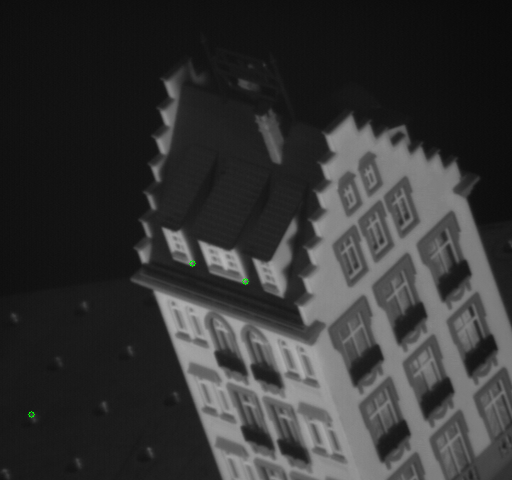

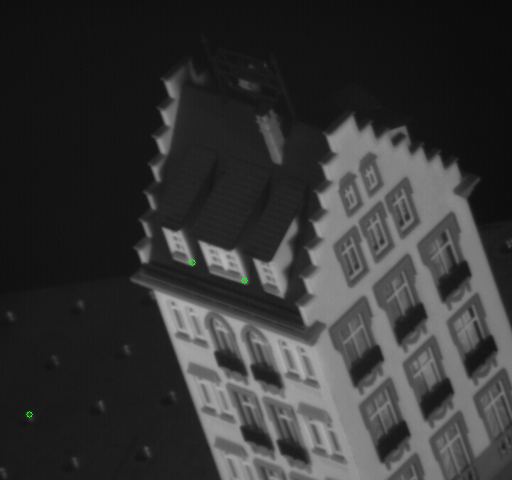

In [8]:
# Test getNextPoints with only a few keypoints, and with only one pair of images

im1 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
im2 = cv2.imread("hotel_images/hotel.seq01.png", cv2.COLOR_BGR2GRAY)
# a few example keypoints
xy = np.array([[192., 263.], [245., 281.], [ 31., 414.]]) 
# initialize this flag to False, to indicate that all keypoints are inside the image
movedOutFlag = np.zeros(xy.shape[0])

xy2, movedOutFlag = getNextPoints(im1, im2, xy, movedOutFlag)
print (f'initial keypoints = {xy}')
print (f'updated keypoints = {xy2}')
print (f'updated flag = {movedOutFlag}')

# For both images, draw a small circle at each keypoint and display the result
DISPLAY_RADIUS = 3
DISPLAY_COLOR = (0, 255, 0)
im1color = cv2.cvtColor(im1, cv2.COLOR_GRAY2BGR)
corners = np.intp(np.round(xy))
for i in corners:
  x, y = i.ravel()
  cv2.circle(im1color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)
cv2_imshow(im1color)

im2color = cv2.cvtColor(im2, cv2.COLOR_GRAY2BGR)
corners = np.intp(np.round(xy2))
for i in corners:
  x, y = i.ravel()
  cv2.circle(im2color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)
cv2_imshow(im2color)


Now that you have tested your tracking code with on a small scale, it is time to work with more keypoints and longer image sequences. 

The next code block provides a suggested structure for the overall tracking solution. The top-level function is **`mainFunction`**, which should generate the required results after you have finished. Examine this top-level function to see how the other functions fit together. Read the comment blocks for more detailed descriptions.

**Write additional code to complete the the next code block.** The only parts that you should need to update are marked "TO DO". The grader should only need to run `mainFunction` in order to generate and see your final KLT tracking results. Write the code so that it automatically displays the following:

*   images showing tracked keypoint locations for t=1 and t=11 and t=50, and possibly for a few more values of t (but do not display all of the images in your final output)
*   at the end, display image 0 that has been updated to show 2D paths that were taken by each keypoint during tracking (an example is given later)



(You are allowed to make further modifications to the code. But in those cases, please provide detailed comments to explain your reasons for making the changes.)




In [9]:
# KLT TRACKING - main code block

# global variables - try to write you code without needing additional globals
NUMBER_OF_IMAGES = 51  # try smaller values here for initial testing
DISPLAY_RADIUS = 3
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)

def mainFunction():
  '''This is the main "driver" function that performs KLT tracking
  '''
  print("In mainFunction")
  allImgs = readImages(NUMBER_OF_IMAGES)
  print (f'number of images that were read = {len(allImgs)}')

  # get initial keypoints from image 0
  image0 = allImgs[0]
  xy = getKeypoints(image0)
  if xy is None:
    print("no points to track!")
    return
  print (f'number of detected keypoints = {xy.shape[0]}')

  # display keypoints for image 0
  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))  
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  # track the initial keypoints through all remaining images
  xyt = trackPoints(xy, allImgs)

  # in image 0, draw the paths taken by the keypoints 
  drawPaths(image0color, xyt)
  return


def readImages(filecount):
  '''Read a sequence of image files, starting with image 0 in 'hotel' sequence
     Input:
      filecount: how many image files to read
     Output:
      allImages: a list of OpenCV images in sequential order 
  '''
  print("In function readImages")
  allImages = []
  for i in range(filecount):
    print (f'reading image {i:02}')
    imagetmp = cv2.imread("hotel_images/hotel.seq" + f'{i:02d}' + ".png", cv2.COLOR_BGR2GRAY)
    allImages.append(imagetmp)
  return allImages


def getKeypoints(im0):
  '''Find keypoints that will be good for tracking;
     you are allowed to copy code directly from keypointDetectionDemo
     Input:
      im0: grayscale source image with shape (m, n)
     Output:
      corners: a numpy array of size kx2, where k is the number of keypoints. 
       Each keypoint is of the form [x, y], where x and y are floating-point
       values that represent image locations in the (horizontal, vertical) 
       directions, respectively. 

     TO DO: Implement the getKeypoints function.
  '''
  print ("In function getKeypoints")
  # replace the following line; it is just a placeholder
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2, 
                       minDistance = 7,  
                       blockSize = 5 )     
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # now corners should contain an array of (floating point) pixel locations 
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # convert to kx2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  return corners
  

def trackPoints(xy, imageSequence):
  '''Track keypoints through the given image sequence
     Input:
      xy: a numpy array containing keypoints for the first image in imageSequence;
       format is identical to 'corners' in getKeypoints
      imageSequence: a list of OpenCV images in sequential order
     Output:
      xyt: <any format that you see fit, as needed by the drawPaths function>

     TO DO: Update the trackPoints function
  '''
  print ("In function trackPoints")
  print (f'length of imageSequence = {len(imageSequence)}')
  movedOutFlag = np.zeros(xy.shape[0])
  # initialize xyt to contain any information that is needed for drawing paths at the end of tracking
  # also add code in this function as needed to maintain xyt
  xyt = []

  for t in range(0, len(imageSequence)-1): # predict for all images except first in sequence
    print (f't = {t}; predicting for t = {t+1}') 
    xy2, movedOutFlag = getNextPoints(imageSequence[t], imageSequence[t+1], xy, movedOutFlag)
    xy = xy2
    xyt.append(xy2)
    # for selected instants in time, display the latest image with highlighted keypoints 
    if ((t == 1) or (t == 11) or (t == 21) or (t == 31) or (t == 41) or (t == 50)):
      im2color = cv2.cvtColor(imageSequence[t+1], cv2.COLOR_GRAY2BGR)
      corners = np.intp(np.round(xy2))  
      for c in range(0, corners.shape[0]):
        if movedOutFlag[c] == False:
          x = corners[c][0]
          y = corners[c][1]
          cv2.circle(im2color, (x, y), DISPLAY_RADIUS, GREEN)
      cv2_imshow(im2color)
    
  return xyt

def drawPaths(im0color, xyt):
  '''In the given image, draw paths that were taken by each keypoint during tracking
     Input:
      im0color: a color image with shape (m, n, 3), typically the first image in a sequence
     Output:
      xyt: <any format that you see fit, as needed for drawing the paths>

     TO DO: Implement the drawPaths function
  '''
  print ("In function drawPaths")

  for point in range(1, len(xyt)):
    for seg in range(1, len(xyt[point])):
      cv2.circle(im0color, xyt[point][seg-1].astype(int), 1, (255,0,0), 1) 


  print ("FINISHED: here are the paths of the tracked keypoints")
  cv2_imshow(im0color)



#Test #2

The grader should only need to run **`mainFunction`** in the next block in order to run your code and see the required output. 

In mainFunction
In function readImages
reading image 00
reading image 01
reading image 02
reading image 03
reading image 04
reading image 05
reading image 06
reading image 07
reading image 08
reading image 09
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
reading image 50
number of images that were read = 51
In function getKeypoints
Number of detected keypoints = 1

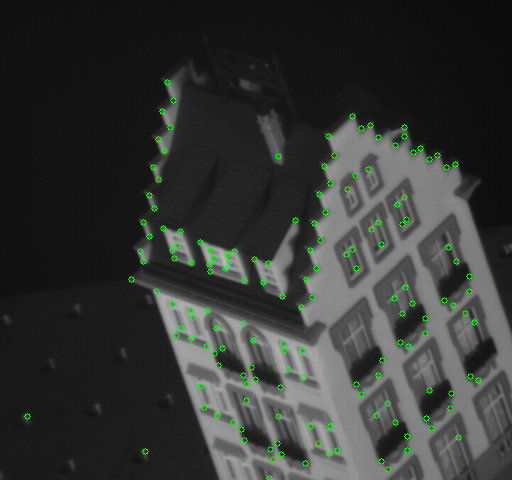

t = 2; predicting for t = 3
In function getNextPoints
t = 3; predicting for t = 4
In function getNextPoints
t = 4; predicting for t = 5
In function getNextPoints
t = 5; predicting for t = 6
In function getNextPoints
t = 6; predicting for t = 7
In function getNextPoints
t = 7; predicting for t = 8
In function getNextPoints
t = 8; predicting for t = 9
In function getNextPoints
t = 9; predicting for t = 10
In function getNextPoints
t = 10; predicting for t = 11
In function getNextPoints
t = 11; predicting for t = 12
In function getNextPoints


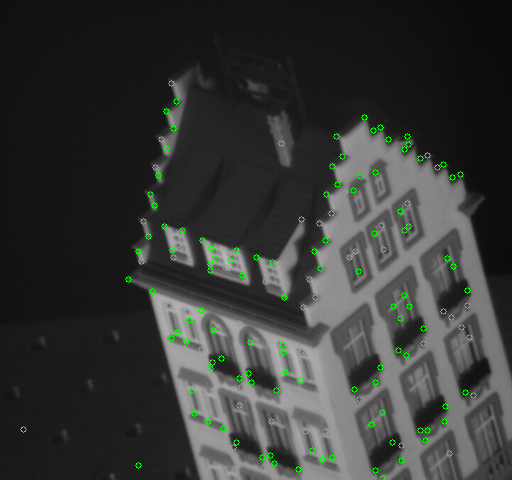

t = 12; predicting for t = 13
In function getNextPoints
t = 13; predicting for t = 14
In function getNextPoints
t = 14; predicting for t = 15
In function getNextPoints
t = 15; predicting for t = 16
In function getNextPoints
t = 16; predicting for t = 17
In function getNextPoints
t = 17; predicting for t = 18
In function getNextPoints
t = 18; predicting for t = 19
In function getNextPoints
t = 19; predicting for t = 20
In function getNextPoints
t = 20; predicting for t = 21
In function getNextPoints
t = 21; predicting for t = 22
In function getNextPoints


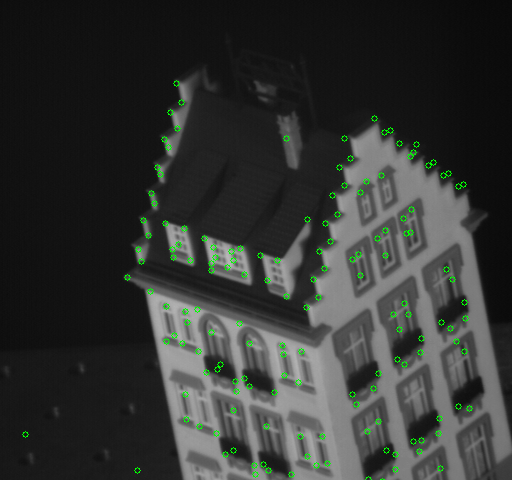

t = 22; predicting for t = 23
In function getNextPoints
t = 23; predicting for t = 24
In function getNextPoints
t = 24; predicting for t = 25
In function getNextPoints
t = 25; predicting for t = 26
In function getNextPoints
t = 26; predicting for t = 27
In function getNextPoints
t = 27; predicting for t = 28
In function getNextPoints
t = 28; predicting for t = 29
In function getNextPoints
t = 29; predicting for t = 30
In function getNextPoints
t = 30; predicting for t = 31
In function getNextPoints
t = 31; predicting for t = 32
In function getNextPoints


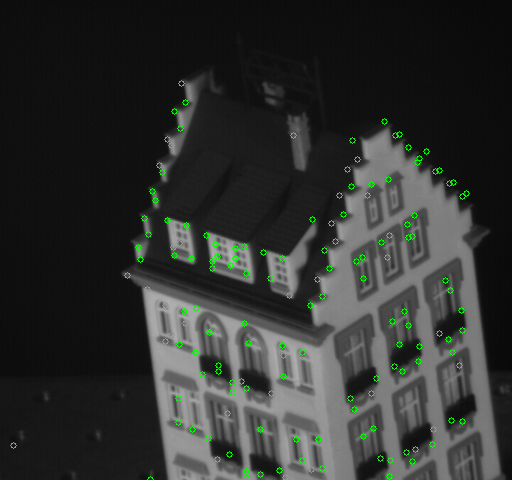

t = 32; predicting for t = 33
In function getNextPoints
t = 33; predicting for t = 34
In function getNextPoints
t = 34; predicting for t = 35
In function getNextPoints
t = 35; predicting for t = 36
In function getNextPoints
t = 36; predicting for t = 37
In function getNextPoints
t = 37; predicting for t = 38
In function getNextPoints
t = 38; predicting for t = 39
In function getNextPoints
t = 39; predicting for t = 40
In function getNextPoints
t = 40; predicting for t = 41
In function getNextPoints
t = 41; predicting for t = 42
In function getNextPoints


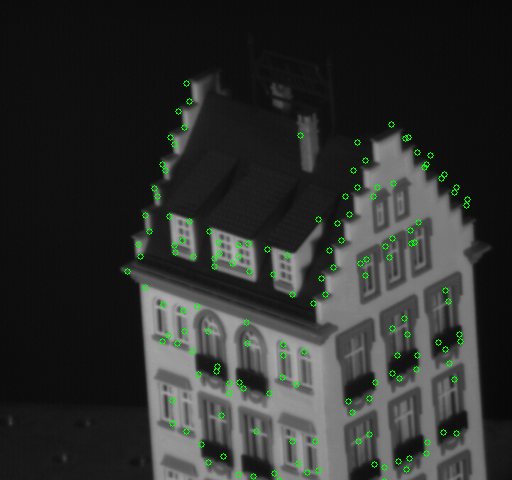

t = 42; predicting for t = 43
In function getNextPoints
t = 43; predicting for t = 44
In function getNextPoints
t = 44; predicting for t = 45
In function getNextPoints
t = 45; predicting for t = 46
In function getNextPoints
t = 46; predicting for t = 47
In function getNextPoints
t = 47; predicting for t = 48
In function getNextPoints
t = 48; predicting for t = 49
In function getNextPoints
t = 49; predicting for t = 50
In function getNextPoints
In function drawPaths
FINISHED: here are the paths of the tracked keypoints


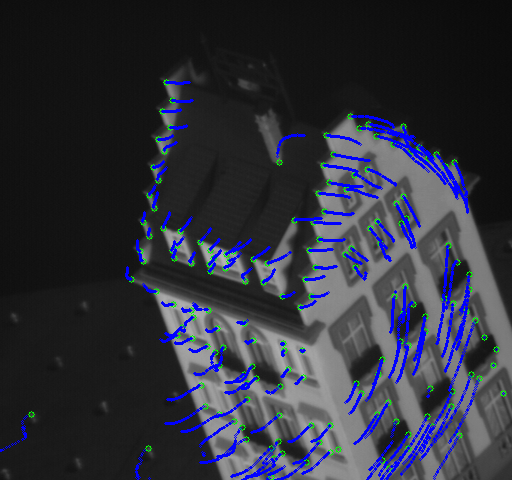

In [10]:
# Run the KLT tracking code
mainFunction()

Here is an example output from `drawPaths`. With close examination, you can see that it is not perfect for all keypoints. It is okay if your result is not perfect, either. (But try to make your output at least this good.)



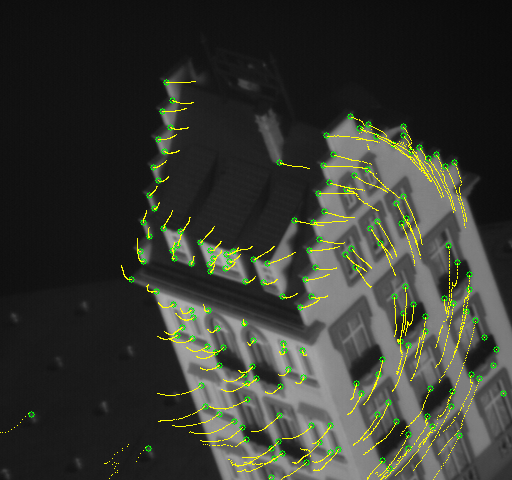



# **Harris Corner Detector**

Below it the custom **getKeypoints_own()** funtion that takes in the image and produces respective corner detections using the Harris corner detection algorithm.

Additional Information:


*   Value for k is chosen to be 0.06 for sharp corners.
*   Default value for threshold on 'R' is 1000.
*   Window size for non-maximal suppression is 5x5.
*   Output fromat is ket same as the earlier getKeypoints function for easy integration.



In [14]:
def getKeypoints_own(im0, R = 1000):
  '''Find keypoints that will be good for tracking;
     you are allowed to copy code directly from keypointDetectionDemo
     Input:
      im0: grayscale source image with shape (m, n)
     Output:
      corners: a numpy array of size kx2, where k is the number of keypoints. 
       Each keypoint is of the form [x, y], where x and y are floating-point
       values that represent image locations in the (horizontal, vertical) 
       directions, respectively. 

     TO DO: Implement the getKeypoints function.
  '''

  k = 0.06
  sx = np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
  sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

  Ix = cv2.Sobel(im0,cv2.CV_8U,1,0)  # 1,0 for x direction
  Iy = cv2.Sobel(im0,cv2.CV_8U,0,1)  # 1,0 for y direction

  Ix2 = Ix*Ix
  Iy2 = Iy*Iy
  Ixy = Ix*Iy

  # Build the H matrix: H = [[Sx2, Sxy]
  #                           Sxy, Sy2]]

  Sx2 = linear_filter(Ix2)
  Sy2 = linear_filter(Iy2)
  Sxy = linear_filter(Ixy)

  det = (Sx2 * Sy2) - (Sxy**2)
  trace = Sx2 + Sy2

  # response for thresholding

  r = det - k*(trace**2)

  # initialize nonmaximal suppression variable that will hold the final set of points

  nms = []
  for i in range(2,im0.shape[0]-2):
    for j in range(2, im0.shape[1]-2):
      if r[i, j] > R:                #only consider successful points > R
        a = r[i-2:i+2, j-2:j+2]      # 5x5 window for max values
        idx = [0,0]
        idx[1]=i-2+ np.unravel_index(a.argmax(), a.shape)[0]   #take argmax and unravel it to return 2D position
        idx[0]=j-2+ np.unravel_index(a.argmax(), a.shape)[1]   # finally add these positions to idx variable
        nms.append(idx)   
        if i < im0.shape[0]-7: #boundary condition
          i+=3                 #skip neighbors to move to next 5x5 window
        elif j < im0.shape[1] -7:
          j+=3
        else:
          pass
                     

  return np.array(nms)

# **Main Function Modifications**



*   Replace getKeypoints() funtion with getKeypoints_own()
*   Keep threshold to be 15000 for acceptable results
*   Perform tracking using these points for full sequence of images




In [17]:
def mainFunction():
  '''This is the main "driver" function that performs KLT tracking
  '''
  print("In mainFunction")
  allImgs = readImages(NUMBER_OF_IMAGES)
  print (f'number of images that were read = {len(allImgs)}')

  # get initial keypoints from image 0
  image0 = allImgs[0]
  xy = getKeypoints_own(image0, 8000)         #  Replacement here 
  if xy is None:
    print("no points to track!")
    return
  print (f'number of detected keypoints = {xy.shape[0]}')

  # display keypoints for image 0
  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))  
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  # track the initial keypoints through all remaining images
  xyt = trackPoints(xy, allImgs)

  # in image 0, draw the paths taken by the keypoints 
  drawPaths(image0color, xyt)
  return